# Classification
It is a problem of predicting if something is one thing or another

* Binary - you have 2 classes
* Multiclass - you have multiple classes(moe than 2)
* Multilabel - you can assign multiple labels to an object

**Input** = *Anything(images...)*

**Output** = *Class probability*

## 1. Make classification data and get it ready

In [191]:
import sklearn
from sklearn.datasets import make_circles

In [192]:
# Make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples, noise=0.03, random_state=42)

print(len(X), len(y))

print("First 5 samples of X:\n ",X[:5], "\nFirst 5 samples of y: ",y[:5])


1000 1000
First 5 samples of X:
  [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 
First 5 samples of y:  [1 1 1 1 0]


In [193]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                         "X2" : X[:,1],
                         "label" : y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


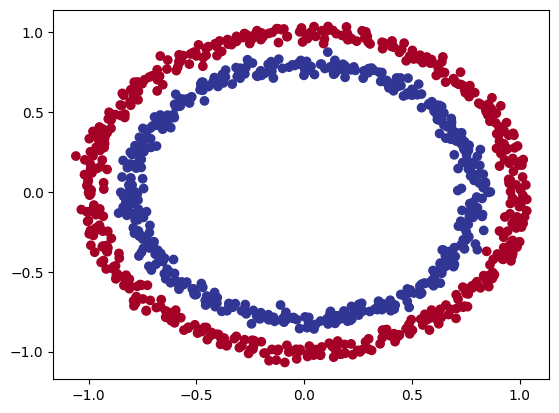

In [194]:
# Visualize, classify if a data point is red or bluew
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is samll enough to experiment but still large enough 

### 1.1 Check input and output shapes

In [195]:
print(X.shape, y.shape) # Numpy arrays

(1000, 2) (1000,)


In [196]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sampole of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and for y: {y_sample.shape}")

Values for one sampole of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [197]:
import torch
torch.__version__

'2.6.0+cu126'

In [198]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [199]:
print(X.dtype, y.dtype)

torch.float32 torch.float32


In [200]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_test))

800 200


## Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to: 
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nnn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [201]:
# Import PyTorch and nn
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've set up device agnostic code, let's create a model that:

1. Subclass `nn.Modulr` (allmost all models in PyToch subclass it)
2. Create 2 `nn.Linear()` layers capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instande of our model class and send it to the target device

In [202]:
# 1. Construct a model that sublclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create two nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        # In features here have to match the out_features in the previous layer (8 -> 8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)

        #self.two_linear_layers = nn.Sequential(
         #   nn.Linear(in_features=2,out_features=8),
         #   nn.Linear(in_features=8, out_features=1)
        #)

    #3. Define a forward method that defines a forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
        #return self.two_linear_layers
    
#4. INstance of our model class, and send it to the target device
model_0 = CircleModelV0().to(device)

print(next(model_0.parameters()).device)


cuda:0


In [203]:
# Let's replicate the model above using nn.Sequential() -> basically does a lot of stuff for us
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1177, -0.2296],
                      [ 0.4370,  0.1102],
                      [ 0.5713,  0.0773],
                      [-0.2230,  0.1900],
                      [-0.1918,  0.2976]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6313,  0.4087, -0.3091,  0.4082,  0.1265], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2271, -0.2726, -0.4427, -0.1728, -0.3430]], device='cuda:0')),
             ('1.bias', tensor([0.3670], device='cuda:0'))])

In [204]:
# Make some predictions
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    
print(f"Length of preditions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictiosn: \n{untrained_preds[:10]}")
print(f"First 10 labbels: {y_test[:10]}")

Length of preditions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictiosn: 
tensor([[0.3407],
        [0.1769],
        [0.6703],
        [0.2477],
        [0.5118],
        [0.4130],
        [0.0773],
        [0.1322],
        [0.6765],
        [0.1641]], device='cuda:0')
First 10 labbels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function of optimiuer should you use?

Again... this is problem specific

For example for regression you might want MAE or MSE (mean absolute error or mean squarred error)

Fro classification you might want binary cross entropy or categorical cross entropy (also just cross entropy)

As a reminder, the loss function measures how *Wrong* your predictions are

And for optimizers, 2 of the most common and useful are SGD and Adam, however PyTorch has many other options

* For the loss function we're going to use `torch.nn.BCEWithLogitcsLoss()`
* For different loss functions and optimiuers look at pytorch docs

In [205]:
# Pick a loss function
loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid before
loss_fn = nn.BCEWithLogitsLoss() # Has the sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.01)

In [206]:
# Calculate accuracy - out of 100 examples what percentage does or model get right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # item gives a single value
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

We need to build a training loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Backpropagation (loss backward)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediciton labels

Our model outputs are going to e rwa **logits**

We can convert thees **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can conver out model's prediction probabilities to **prediction labels** by either roundingthem or taing the `argmax()`

In [207]:
# view the first 5 outputs of the forward pas on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits


tensor([[0.3407],
        [0.1769],
        [0.6703],
        [0.2477],
        [0.5118]], device='cuda:0')

In [208]:
# Use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5844],
        [0.5441],
        [0.6616],
        [0.5616],
        [0.6252]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` -> class 1
* `y_pred_probs` <= 0.5, `y=0` -> class 0

In [209]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

# In full: logits -> pred probs ->pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of etra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### 3.2 Building a training and test loop

In [210]:
# Train loop
model_0.to(device)
torch.manual_seed(42)
epochs = 2000

X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ## Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss and accuracy
    acc = accuracy_fn(y_train, y_pred)
    # We have to put in logits because of the loss function we picked 
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input, if we did withot logits, we would need torch.sigmoid(y_logits), since it expects probabilites

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. bacpropagation
    loss.backward()

    #5. Optimizer the step (gradient descent)
    optimizer.step()

    ### Testing 
    model_0.eval()
    with torch.inference_mode():
        #1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_test, test_pred)

    # Print out what is happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.2f} | acc: {acc:.2f} | test loss: {test_loss:.2f} | test acc: {test_acc:.2f}")


Epoch: 0 | loss: 0.72 | acc: 50.00 | test loss: 0.71 | test acc: 50.00
Epoch: 10 | loss: 0.72 | acc: 50.00 | test loss: 0.71 | test acc: 50.00
Epoch: 20 | loss: 0.72 | acc: 50.00 | test loss: 0.71 | test acc: 50.00
Epoch: 30 | loss: 0.72 | acc: 50.12 | test loss: 0.71 | test acc: 50.00
Epoch: 40 | loss: 0.71 | acc: 50.75 | test loss: 0.70 | test acc: 52.00
Epoch: 50 | loss: 0.71 | acc: 54.00 | test loss: 0.70 | test acc: 56.00
Epoch: 60 | loss: 0.71 | acc: 56.62 | test loss: 0.70 | test acc: 58.00
Epoch: 70 | loss: 0.71 | acc: 57.75 | test loss: 0.70 | test acc: 59.00
Epoch: 80 | loss: 0.71 | acc: 59.00 | test loss: 0.70 | test acc: 60.50
Epoch: 90 | loss: 0.71 | acc: 58.13 | test loss: 0.70 | test acc: 57.50
Epoch: 100 | loss: 0.71 | acc: 56.62 | test loss: 0.70 | test acc: 54.50
Epoch: 110 | loss: 0.71 | acc: 55.75 | test loss: 0.70 | test acc: 54.50
Epoch: 120 | loss: 0.71 | acc: 54.37 | test loss: 0.70 | test acc: 54.50
Epoch: 130 | loss: 0.70 | acc: 54.37 | test loss: 0.70 | test 

## 4. Make predictions and evaluate the model 

From the metrcics it looks like our model isn't learning anything

Let's visualize!

To do so we're going to import a fuction called `plot_decision_boundary()`

In [211]:
import requests
from pathlib import Path

# downlad helper functions from Learn PyTorch repo (if it isn't already downloaded)
if Path("helper_functions.py").is_file():
    print("helpe_functions.py already exists!")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helpe_functions.py already exists!


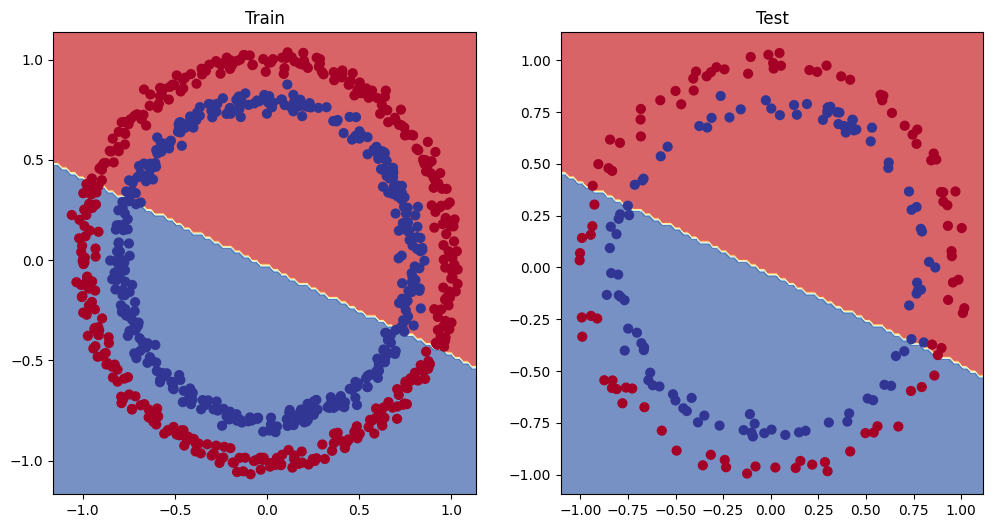

In [212]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate 

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as data scientists) can change, they are referred to as **hyperparameters**.

Let's try to improve our model by (gennerally only change one thing and keep track of stuff):
* Adding more hidden units
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

Exploding gradient problem, Vanishig gradient problem

In [213]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        # z = self.layer_1(x)
        # z = self.layer_2(z) 
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing leverages sped ups where possible behind the scenec


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [214]:
# Create a loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# Select an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.01)

In [215]:
# Training loop 
epochs = 1000

torch.manual_seed(42)

model_1 = model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):

    y_pred_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_pred_logits))

    loss = loss_fn(y_pred_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ## testing
    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss= loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss: {loss} | acc: {acc}% | test loss: {test_loss} | test acc: {test_acc}%")





epoch: 0 | loss: 0.6967406868934631 | acc: 50.24999999999999% | test loss: 0.7048701047897339 | test acc: 48.0%
epoch: 100 | loss: 0.6956406235694885 | acc: 50.5% | test loss: 0.7030588984489441 | test acc: 48.0%
epoch: 200 | loss: 0.6949262619018555 | acc: 50.625% | test loss: 0.7017045617103577 | test acc: 47.5%
epoch: 300 | loss: 0.6944354772567749 | acc: 50.5% | test loss: 0.7006480097770691 | test acc: 47.0%
epoch: 400 | loss: 0.694085955619812 | acc: 50.875% | test loss: 0.6998016238212585 | test acc: 46.0%
epoch: 500 | loss: 0.6938308477401733 | acc: 50.74999999999999% | test loss: 0.6991102695465088 | test acc: 46.0%
epoch: 600 | loss: 0.6936410069465637 | acc: 51.0% | test loss: 0.6985366940498352 | test acc: 46.5%
epoch: 700 | loss: 0.6934976577758789 | acc: 50.875% | test loss: 0.69805508852005 | test acc: 46.5%
epoch: 800 | loss: 0.693388044834137 | acc: 50.74999999999999% | test loss: 0.6976463198661804 | test acc: 47.0%
epoch: 900 | loss: 0.6933033466339111 | acc: 50.875%

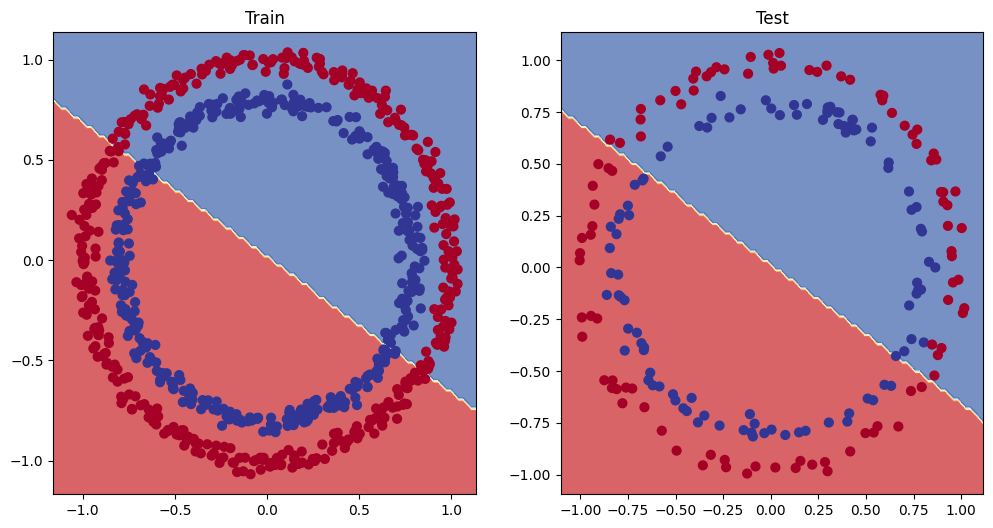

In [216]:
# Plot the decision boundary 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line 

One way to troubleshoot a larger problem is to test out a smaller problem


In [217]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data 
print(len(X_regression))
X_regression[:5], y_regression

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630],
         [0.3700],
         [0.3770],
         [0.3840],
         [0.3910],
         [0.3980],
         [0.4050],
         [0.4120],
         [0.4190],
         [0.4260],
         [0.4330],
         [0.4400],
         [0.4470],
         [0.4540],
         [0.4610],
         [0.4680],
         [0.4750],
         [0.4820],
         [0.4890],
         [0.4960],
         [0.5030],
         [0.5100],
         [0.5170],
         [0.5240],
         [0.5310],
         [0.5380],
         [0.5450],
         [0.5520],
         [0.5590],
         [0.5660],
         [0.5730],
         [0.5800],
         [0.5870],
         [0.5940],
         [0.6010],
         [0.6080],
         [0.6150],
         [0.6220],
         [

In [218]:
# Create train and test splits
train_split = int(0.8 *  len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regressoin = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regressoin)

(80, 20, 80, 20)

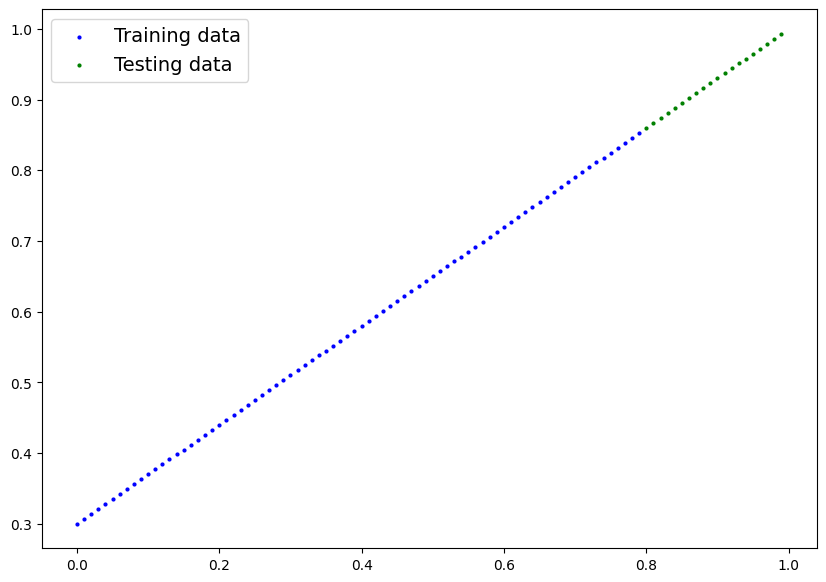

In [219]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regressoin)

In [220]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2 Adjusting `model_1` to fit a straight line 

In [221]:
# same architecture as model_1 but (nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [222]:
# Loss and optimizer 
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.01)

In [223]:
epochs = 1000

torch.manual_seed(42)
torch.cuda.manual_seed(42)


X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regressoin = X_test_regression.to(device), y_test_regressoin.to(device)

for epoch in range(epochs):
    
    model_2.train()
    y_pred = model_2(X_train_regression) 

    loss = loss_fn(y_pred, y_train_regression)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regressoin)

    if epoch%100 == 0:
        print(f"epoch: {epoch} | loss : {loss} | test loss : {test_loss}")


epoch: 0 | loss : 0.7598585486412048 | test loss : 0.9110288619995117
epoch: 100 | loss : 0.02857949770987034 | test loss : 0.0008127153269015253
epoch: 200 | loss : 0.025325385853648186 | test loss : 0.0020920156966894865
epoch: 300 | loss : 0.021374789997935295 | test loss : 0.003050941275432706
epoch: 400 | loss : 0.019644932821393013 | test loss : 0.0034077109303325415
epoch: 500 | loss : 0.01940224878489971 | test loss : 0.003872519824653864
epoch: 600 | loss : 0.019032439216971397 | test loss : 0.0037890374660491943
epoch: 700 | loss : 0.018782947212457657 | test loss : 0.0038133622147142887
epoch: 800 | loss : 0.018397359177470207 | test loss : 0.003287202212959528
epoch: 900 | loss : 0.01798025146126747 | test loss : 0.003603678895160556


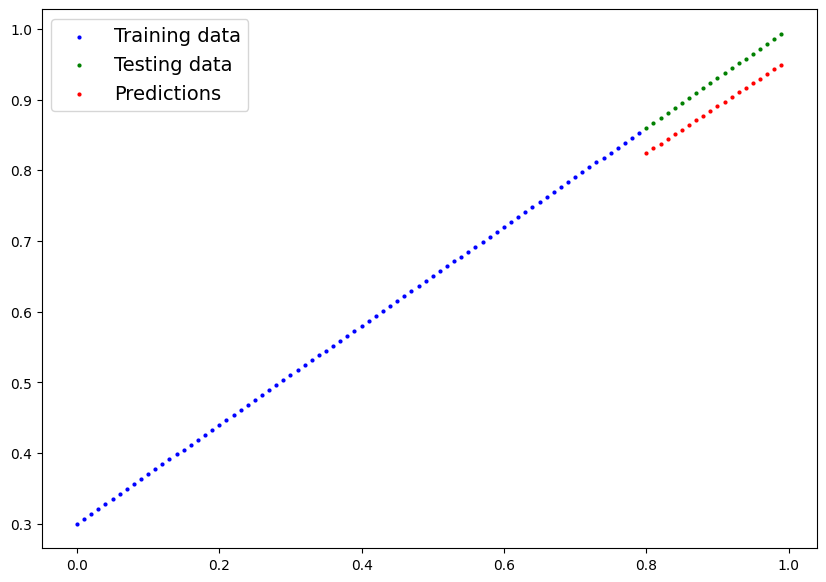

In [224]:
import numpy as np
# turn on evaluation mode
model_2.eval()

# make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)



# plot the data and predictions
plot_predictions((X_train_regression).cpu(), y_train_regression.cpu(), X_test_regression.cpu(), y_test_regressoin.cpu(), y_preds.cpu())

## 6. The missing piece: non-linearity 

"What patterns could you draw if you were give an infinite amount of straight and non-straight lines?"

Or in ML terms, in infinite (but really finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

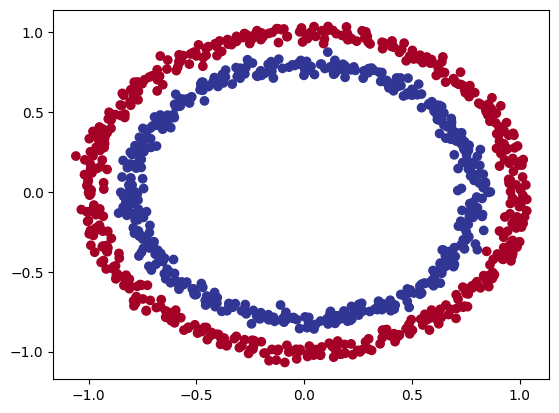

In [225]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, 
                 noise = 0.03,
                 random_state= 42)

plt.scatter(X[:,0], X[:,1], c=y, cmap= plt.cm.RdYlBu)

In [226]:
# convert data to tensors and then to train and tst splits
import torch 
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= 0.8, random_state=42)

X_train[:5], y_train[:5]


(tensor([[-0.0597, -0.9970],
         [-0.5320,  0.5567],
         [ 0.9656, -0.4018],
         [ 0.0764,  0.7993],
         [ 0.6488,  0.4942]]),
 tensor([0., 1., 0., 1., 1.]))